In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [16]:
!pip install --upgrade tensorflow

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 284.1/284.1 MB 3.2 MB/s eta 0:00:00
     -------------------------------------- 430.5/430.5 kB 6.7 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 4.9 MB/s eta 0:00:00
     ---------------------------------------- 15.8/15.8 MB 5.0 MB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 6.9 MB/s eta 0:00:00
     -------------------------------------- 938.4/938.4 kB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 6.9 MB/s eta 0:00:00
     ------------------------------------- 182.3/182.3 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 22.10.26
    Uninstalling flatbuffers-22.10.26:
      Successfully uninstalled flatbuffers-22.10.26
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Admin\\AppData\\Roaming\\Python\\Python39\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Check the permissions.


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

68606236/68606236 [==============================] - 6s 0us/step
Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


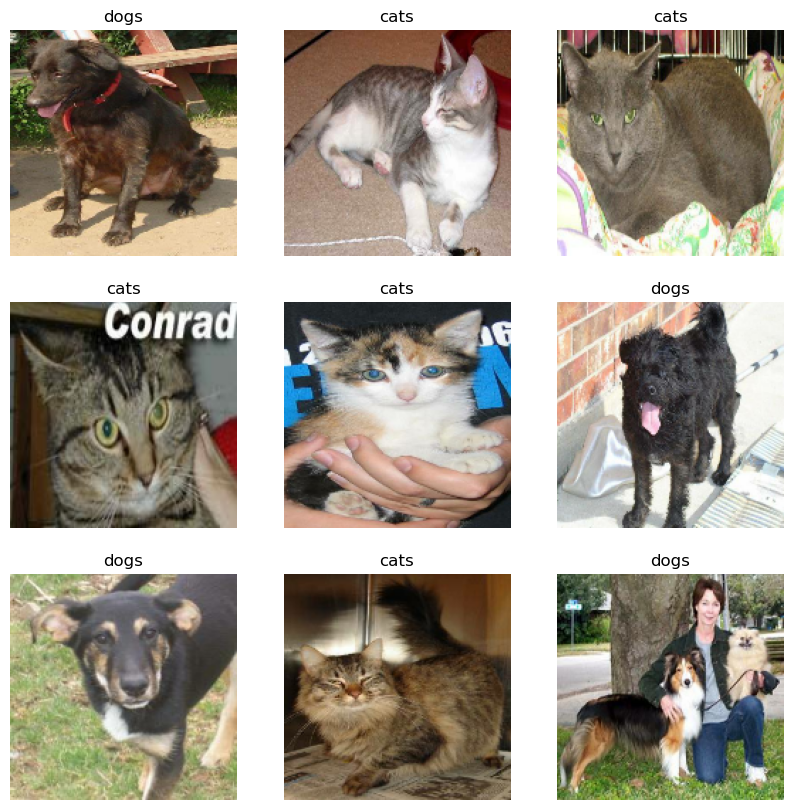

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

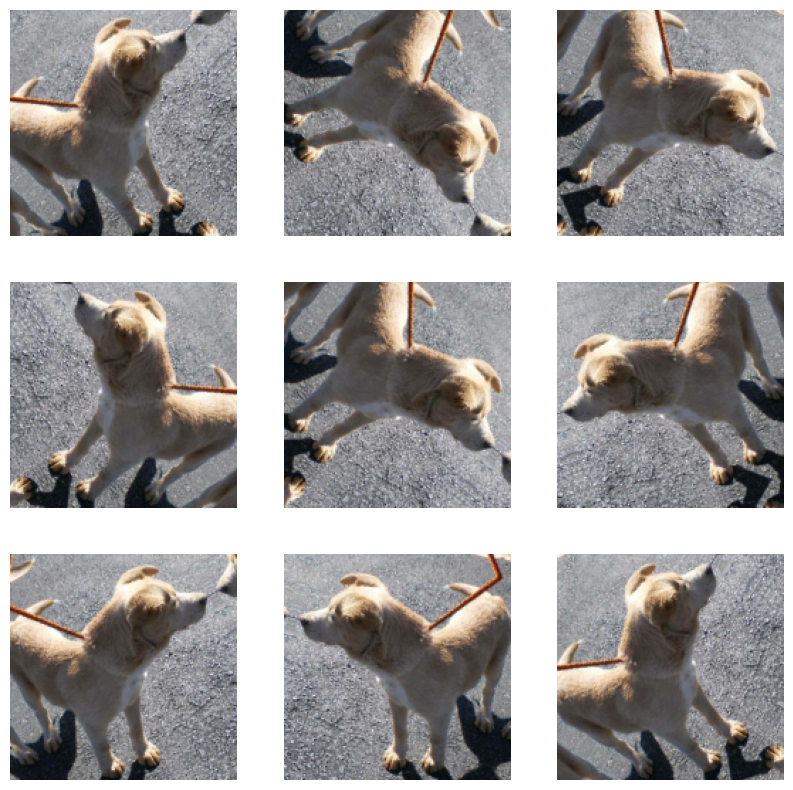

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [13]:
# Create the base model from the pre-trained model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [16]:
base_model.trainable = False

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

 block_3_expand_relu (ReLU)  (None, 40, 40, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 41, 41, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 20, 20, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 20, 20, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [23]:
len(model.trainable_variables)

2

In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 8s 229ms/step - loss: 0.9452 - accuracy: 0.4604


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.95
initial accuracy: 0.46


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 26s 362ms/step - loss: 0.8072 - accuracy: 0.5370 - val_loss: 0.5911 - val_accuracy: 0.6374
Epoch 2/10
63/63 [==============================] - 31s 497ms/step - loss: 0.5955 - accuracy: 0.6560 - val_loss: 0.4416 - val_accuracy: 0.7698
Epoch 3/10
63/63 [==============================] - 34s 543ms/step - loss: 0.4916 - accuracy: 0.7345 - val_loss: 0.3351 - val_accuracy: 0.8478
Epoch 4/10
63/63 [==============================] - 36s 563ms/step - loss: 0.4090 - accuracy: 0.7980 - val_loss: 0.2746 - val_accuracy: 0.8886
Epoch 5/10
63/63 [==============================] - 32s 513ms/step - loss: 0.3552 - accuracy: 0.8240 - val_loss: 0.2326 - val_accuracy: 0.9084
Epoch 6/10
63/63 [==============================] - 30s 482ms/step - loss: 0.3138 - accuracy: 0.8525 - val_loss: 0.2008 - val_accuracy: 0.9233
Epoch 7/10
63/63 [==============================] - 34s 543ms/step - loss: 0.2852 - accuracy: 0.8690 - val_loss: 0.1789 - val_accuracy: 0.9295

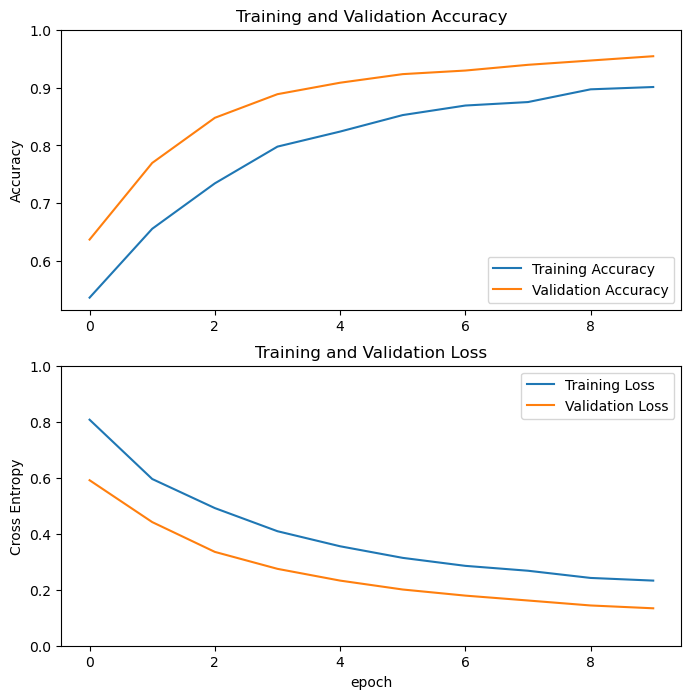

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,epochs=total_epochs,initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 41s 583ms/step - loss: 0.1690 - accuracy: 0.9325 - val_loss: 0.0577 - val_accuracy: 0.9814
Epoch 11/20
63/63 [==============================] - 40s 639ms/step - loss: 0.1274 - accuracy: 0.9480 - val_loss: 0.0627 - val_accuracy: 0.9703
Epoch 12/20
63/63 [==============================] - 39s 624ms/step - loss: 0.1155 - accuracy: 0.9545 - val_loss: 0.0473 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 41s 645ms/step - loss: 0.1035 - accuracy: 0.9575 - val_loss: 0.0740 - val_accuracy: 0.9715
Epoch 14/20
63/63 [==============================] - 44s 700ms/step - loss: 0.0992 - accuracy: 0.9590 - val_loss: 0.0499 - val_accuracy: 0.9790
Epoch 15/20
63/63 [==============================] - 128s 2s/step - loss: 0.0861 - accuracy: 0.9680 - val_loss: 0.0410 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 41s 654ms/step - loss: 0.0784 - accuracy: 0.9690 - val_loss: 0.0403 - val_accuracy: 0

In [33]:
len(model.trainable_variables)


56

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_dataset,epochs=total_epochs,initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 35s 554ms/step - loss: 0.0565 - accuracy: 0.9795 - val_loss: 0.0456 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 44s 695ms/step - loss: 0.0567 - accuracy: 0.9780 - val_loss: 0.0375 - val_accuracy: 0.9864
Epoch 12/20
63/63 [==============================] - 40s 639ms/step - loss: 0.0494 - accuracy: 0.9790 - val_loss: 0.0448 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 41s 650ms/step - loss: 0.0400 - accuracy: 0.9830 - val_loss: 0.0368 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 42s 667ms/step - loss: 0.0404 - accuracy: 0.9840 - val_loss: 0.0466 - val_accuracy: 0.9790
Epoch 15/20
63/63 [==============================] - 41s 654ms/step - loss: 0.0345 - accuracy: 0.9835 - val_loss: 0.0589 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 40s 632ms/step - loss: 0.0419 - accuracy: 0.9850 - val_loss: 0.0404 - val_accuracy:

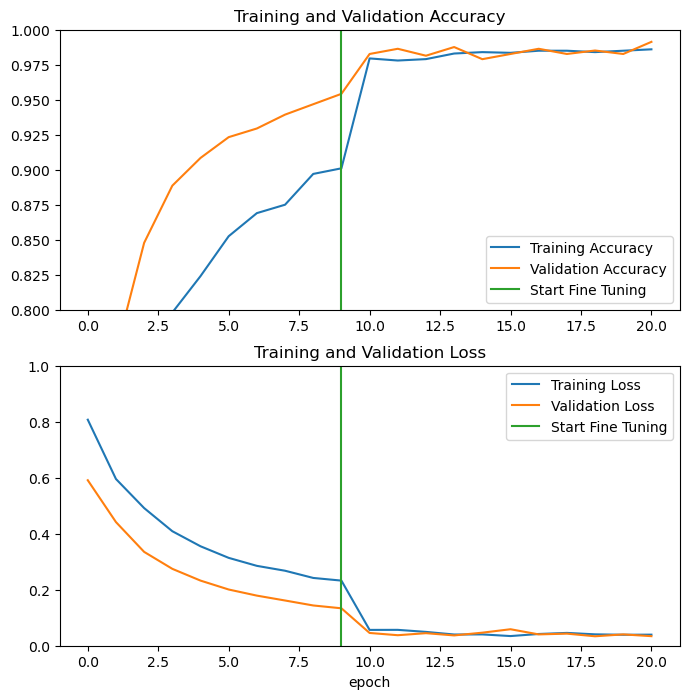

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
base_model.trainable = True

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [39]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 234ms/step - loss: 0.0226 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


Predictions:
 [0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0]
Labels:
 [0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0]


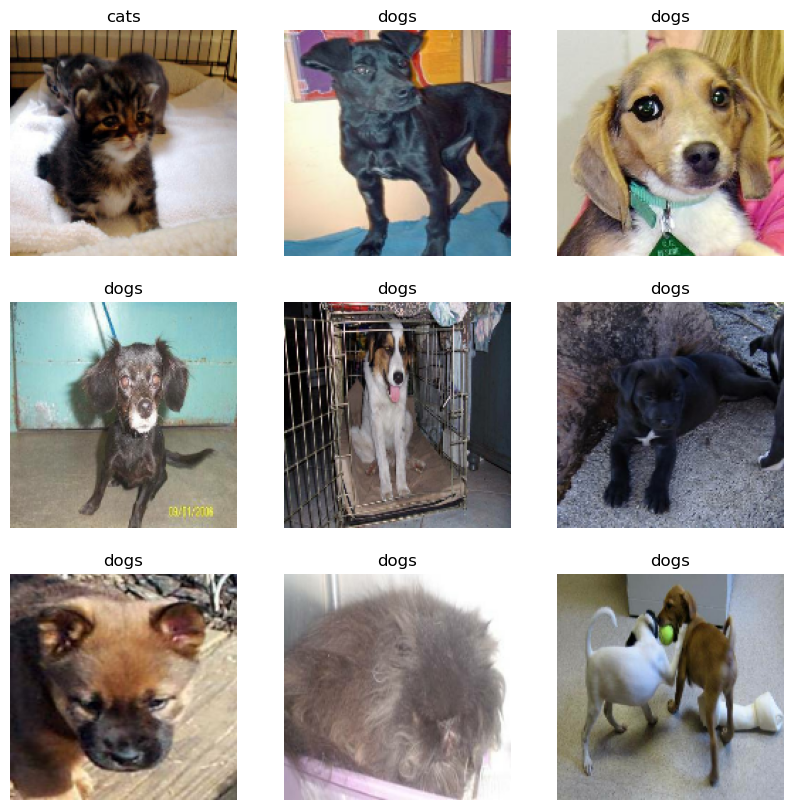

In [40]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")